# RAG-проект по роману «Обломов» И.А. Гончарова

Этот проект представляет собой специализированный раг-пайплайн, интегрирующий современные LLM-модели для анализа романа И.А. Гончарова "Обломов". Система включает два ключевых компонента:

1. Поисковый модуль, использующий векторные базы данных для быстрого поиска релевантных отрывков текста по пользовательским запросам.
2. Генеративный компонент на базе LLM, способный генерировать развернутые ответы на вопросы о персонажах, темах и событиях произведения.

## Цели и задачи

**Цель:** создать интеллектуальную систему, которая способна отвечать на вопросы по роману *«Обломов»* с использованием технологии Retrieval-Augmented Generation.

**Задачи:**
- провести предобработку текста книги и разделить его на фрагменты (chunking);
- построить эмбеддинги и базу векторного поиска;
- реализовать RAG-модель, объединяющую поиск и генерацию.


## 1 Обработка текста и создание эмбенддингов

Сначала устанавливаю необходимые библиотеки

In [7]:
!pip install PyMuPDF
!pip install tqdm
!pip install sentence-transformers
!pip install accelerate

In [8]:
!pip install -U spacy -q
!python -m spacy download ru_core_news_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 29.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
import os
import fitz
from tqdm.auto import tqdm
import random
import pandas as pd
import spacy

### 1.1 Импортирую PDF-файл. Каждая страница текста сохраняется в словаре, затем передается в список для дальнейшего удобства использования

In [10]:
pdf_path = 'Oblomov.pdf'

def text_formatter(text: str) -> str:

    cleaned_text = text.replace("\n", " ").strip()


    return cleaned_text


def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open('Oblomov.pdf')
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number + 1,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]



0it [00:00, ?it/s]

[{'page_number': 1,
  'page_char_count': 2386,
  'page_word_count': 406,
  'page_sentence_count_raw': 13,
  'page_token_count': 596.5,
  'text': 'Иван Александрович Гончаров    Обломов    ЧАСТЬ ПЕРВАЯ    I    В Гороховой улице, в одном из больших домов, народонаселения  которого стало бы на целый уездный город, лежал утром в постели, на своей  квартире, Илья Ильич Обломов.  Это был человек лет тридцати двух-трех от роду, среднего роста,  приятной наружности, с темно-серыми глазами, но с отсутствием всякой  определенной идеи, всякой сосредоточенности в чертах лица. Мысль гуляла  вольной птицей по лицу, порхала в глазах, садилась на полуотворенные губы,  пряталась в складках лба, потом совсем пропадала, и тогда во всем лице  теплился ровный свет беспечности. С лица беспечность переходила в позы  всего тела, даже в складки шлафрока.  Иногда взгляд его помрачался выражением будто усталости или  скуки; но ни усталость, ни скука не могли ни на минуту согнать с лица  мягкость, которая была го

In [11]:
random.sample(pages_and_texts, k=3)

[{'page_number': 220,
  'page_char_count': 2490,
  'page_word_count': 438,
  'page_sentence_count_raw': 24,
  'page_token_count': 622.5,
  'text': '- Да ты прежде шагни два раза, а там...  "Что ж это такое? - печально думал Обломов. - Ни продолжительного  шепота, ни таинственного уговора слить обе жизни в одну! Все как-то иначе,  по-другому. Какая странная эта Ольга! Она не останавливается на одном  месте, не задумывается сладко над поэтической минутой, как будто у ней  вовсе нет мечты, нет потребности утонуть в раздумье! Сейчас и поезжай в  палату, на квартиру - точно Андрей! Что это все они как будто сговорились  торопиться жить!"  На другой день он, с листом гербовой бумаги, отправился в город,  сначала в палату, и ехал нехотя, зевая и глядя по сторонам. Он не знал  хорошенько, где палата, и заехал к Ивану Герасимычу спросить, в каком  департаменте нужно засвидетельствовать.  Тот обрадовался Обломову и без завтрака не хотел отпустить. Потом  послал еще за приятелем, чтоб допроситься

### 1.2 Предварительный EDA

In [12]:
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,1,2386,406,13,596.50,Иван Александрович Гончаров Обломов ЧАСТ...
1,2,2809,475,21,702.25,плечу все шире и шире. Хотя халат этот и утрат...
2,3,2754,473,25,688.50,тарелка с солонкой и с обглоданной косточкой д...
3,4,2712,469,20,678.00,"В комнате, которая отделялась только небольшим..."
4,5,2438,470,26,609.50,"Захар ушел, а Илья Ильич продолжал лежать и ду..."


In [13]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,370.00,370.00,370.00,370.00,370.00
mean,185.50,2549.63,466.31,26.03,637.41
std,106.95,240.96,34.53,7.84,60.24
min,1.00,1729.00,346.00,10.00,432.25
25%,93.25,2392.25,445.00,20.00,598.06
50%,185.50,2577.50,469.00,26.00,644.38
75%,277.75,2739.00,491.00,32.00,684.75
max,370.00,3159.00,576.00,52.00,789.75


Среднее количество токенов на странице равно 637.

В данном конкретном случае это означает, что можно встроить менее 1 страницы с использованием модели distiluse-base-multilingual-cased-v2 (эта модель имеет пропускную способность 512).

### 1.3 Разбиение страниц на предложения

In [14]:
nlp = spacy.load("ru_core_news_sm")


if "sentencizer" not in nlp.pipe_names:
    nlp.add_pipe("sentencizer")


text = "Обломов сидел в халате. Он не хотел вставать. Его мысли текли медленно."


doc = nlp(text)


assert len(list(doc.sents)) == 3


print(list(doc.sents))
print([sent.text for sent in doc.sents])

[Обломов сидел в халате., Он не хотел вставать., Его мысли текли медленно.]
['Обломов сидел в халате.', 'Он не хотел вставать.', 'Его мысли текли медленно.']


In [15]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)


    item["sentences"] = [str(sentence) for sentence in item["sentences"]]


    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/370 [00:00<?, ?it/s]

In [16]:
random.sample(pages_and_texts, k=1)

[{'page_number': 52,
  'page_char_count': 2819,
  'page_word_count': 494,
  'page_sentence_count_raw': 19,
  'page_token_count': 704.75,
  'text': 'Если нужно было постращать дворника, управляющего домом, даже  самого хозяина, он стращал всегда барином. "Вот постой, я скажу барину, -  говорил он с угрозой, - будет ужо тебе!" Сильнее авторитета он и не  подозревал на свете.  Но наружные отношения Обломова с Захаром были всегда как-то  враждебны. Они, живучи вдвоем, надоели друг другу. Короткое, ежедневное  сближение человека с человеком не обходится ни тому, ни другому даром:  много надо и с той и с другой стороны жизненного опыта, логики и  сердечной теплоты, чтоб, наслаждаясь только достоинствами, не колоть и не  колоться взаимными недостатками.  Илья Ильич знал уже одно необъятное достоинство Захара -  преданность к себе, и привык к ней, считая также, с своей стороны, что это  не может и не должно быть иначе; привыкши же к достоинству однажды  навсегда, он уже не наслаждался им, а ме

In [17]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,370.00,370.00,370.00,370.00,370.00,370.00
mean,185.50,2549.63,466.31,26.03,637.41,36.31
std,106.95,240.96,34.53,7.84,60.24,13.63
min,1.00,1729.00,346.00,10.00,432.25,10.00
25%,93.25,2392.25,445.00,20.00,598.06,24.00
50%,185.50,2577.50,469.00,26.00,644.38,37.00
75%,277.75,2739.00,491.00,32.00,684.75,47.00
max,370.00,3159.00,576.00,52.00,789.75,70.00


In [18]:
num_sentence_chunk_size = 15


def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:

    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]


for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/370 [00:00<?, ?it/s]

In [19]:
random.sample(pages_and_texts, k=1)

[{'page_number': 93,
  'page_char_count': 2585,
  'page_word_count': 442,
  'page_sentence_count_raw': 20,
  'page_token_count': 646.25,
  'text': 'деле оно - не то мочальное, не то веревочное: кожи-то осталось только на  спинке один клочок, а остальная уж пять лет как развалилась в куски и  слезла; оттого же, может быть, и ворота все кривы и крыльцо шатается. Но  заплатить за что-нибудь, хоть самонужнейшее, вдруг двести, триста, пятьсот  рублей казалось им чуть не самоубийством.  Услыхав.. что один из окрестных молодых помещиков ездил в Москву  и заплатил там за дюжину рубашек триста рублей, двадцать пять рублей за  сапоги и сорок рублей за жилет к свадьбе, старик Обломов перекрестился и  сказал с выражением ужаса, скороговоркой, что "этакого молодца надо  посадить в острог".  Вообще они глухи были к политико-экономическим истинам о  необходимости быстрого и живого обращения капиталов, об усиленной  производительности и мене продуктов. Они в простоте души понимали и  приводили в испол

In [20]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,370.00,370.00,370.00,370.00,370.00,370.00,370.00
mean,185.50,2549.63,466.31,26.03,637.41,36.31,2.88
std,106.95,240.96,34.53,7.84,60.24,13.63,0.94
min,1.00,1729.00,346.00,10.00,432.25,10.00,1.00
25%,93.25,2392.25,445.00,20.00,598.06,24.00,2.00
50%,185.50,2577.50,469.00,26.00,644.38,37.00,3.00
75%,277.75,2739.00,491.00,32.00,684.75,47.00,4.00
max,370.00,3159.00,576.00,52.00,789.75,70.00,5.00


In [21]:
import re


pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]


        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)
        chunk_dict["sentence_chunk"] = joined_sentence_chunk


        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)


len(pages_and_chunks)

  0%|          | 0/370 [00:00<?, ?it/s]

1066

In [22]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 366,
  'sentence_chunk': 'а Андрюшу выпросили на воспитание Штольц и жена и считают его членом своего семейства.Агафья Матвеевна никогда не равняла и не смешивала участи Андрюши с судьбою первых детей своих, хотя в сердце своем, может быть бессознательно, и давала им всем равное место.Но воспитание, образ жизни, будущую жизнь Андрюши она отделяла целой бездной от жизни Ванюши и Машеньки. - Те что?Такие же замарашки, как я сама, - небрежно говорила она, - они родились в черном теле, а этот, - прибавляла она почти с уважением об Андрюше и с некоторою если не робостью, то осторожностью лаская его, - этот - барчонок!Вон он какой беленький, точно наливной; какие маленькие ручки и ножки, а волоски, как шелк.Весь в покойника! Поэтому она беспрекословно, даже с некоторою радостью, согласилась на предложение Штольца взять его на воспитание, полагая, что там его настоящее место, а не тут, "в черноте", с грязными ее племянниками, детками братца. С полгода по смерти Обломова жила 

In [23]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1066.00,1066.00,1066.00,1066.00
mean,186.39,862.46,140.01,215.62
std,107.50,558.26,87.94,139.56
min,1.00,5.00,1.00,1.25
25%,96.00,512.00,84.00,128.00
50%,190.00,725.00,120.00,181.25
75%,276.00,1056.25,172.00,264.06
max,370.00,2930.00,500.00,732.50


### 1.4 Создание эмбеддингов

Импортрую модель distiluse-base-multilingual-cased-v2 для создания эмбеддингов

In [24]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="distiluse-base-multilingual-cased-v2",
                                      device="cpu")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [25]:
%%time


embedding_model.to("cpu")


for item in tqdm(pages_and_chunks):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1066 [00:00<?, ?it/s]

CPU times: user 2min 57s, sys: 737 ms, total: 2min 58s
Wall time: 2min 59s


In [26]:
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks]

In [27]:
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32,
                                               convert_to_tensor=True)

text_chunk_embeddings

tensor([[-0.0206,  0.0108, -0.0441,  ...,  0.0124, -0.0029,  0.0261],
        [ 0.0103,  0.0190,  0.0354,  ...,  0.0202, -0.0312,  0.0043],
        [-0.0110,  0.0138,  0.0648,  ...,  0.0036, -0.0190,  0.0374],
        ...,
        [ 0.0441,  0.0132,  0.0191,  ...,  0.0063,  0.0273,  0.0015],
        [ 0.0187,  0.0259, -0.0322,  ..., -0.0003,  0.0187,  0.0132],
        [ 0.0458,  0.0025, -0.0289,  ...,  0.0046,  0.0305,  0.0261]])

### 1.5 Сохранение эмбеддингов в csv файл

In [28]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [29]:
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,1,Иван Александрович Гончаров Обломов ЧАСТЬ ПЕ...,2335,355,583.75,[-2.05821749e-02 1.08202565e-02 -4.40772064e-...
1,2,плечу все шире и шире.Хотя халат этот и утрати...,1871,287,467.75,[ 0.01025337 0.01901552 0.03540536 -0.042603...
2,2,"Задок у одного дивана оселся вниз, наклеенное ...",882,133,220.50,[-1.09641412e-02 1.38461636e-02 6.47770241e-...
3,3,тарелка с солонкой и с обглоданной косточкой д...,1707,257,426.75,[-7.80191086e-03 1.91717315e-02 2.62912177e-...
4,3,"Но план был еще далеко не весь обдуман, а непр...",988,158,247.00,[-0.01965263 0.02545456 0.01524404 -0.015158...


## 2 Поиск по сходству

Подготавливаю эмбеддинги к использованию, преобразовывая в тензор

In [30]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"


text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")


text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))


pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")


embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1066, 512])

In [31]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,1,Иван Александрович Гончаров Обломов ЧАСТЬ ПЕ...,2335,355,583.75,"[-0.0205821749, 0.0108202565, -0.0440772064, -..."
1,2,плечу все шире и шире.Хотя халат этот и утрати...,1871,287,467.75,"[0.01025337, 0.01901552, 0.03540536, -0.042603..."
2,2,"Задок у одного дивана оселся вниз, наклеенное ...",882,133,220.50,"[-0.0109641412, 0.0138461636, 0.0647770241, 0...."
3,3,тарелка с солонкой и с обглоданной косточкой д...,1707,257,426.75,"[-0.00780191086, 0.0191717315, 0.0262912177, -..."
4,3,"Но план был еще далеко не весь обдуман, а непр...",988,158,247.00,"[-0.01965263, 0.02545456, 0.01524404, -0.01515..."


Подготавливаю модель для встраивания

In [32]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="distiluse-base-multilingual-cased-v2",
                                      device=device)

In [33]:
# 1. Формирую запрос

query = "Алексеев"
print(f"Query: {query}")

# 2. Вставляю запрос в то же числовое пространство, что и текст

query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Получаю оценку сходства с помощью точечного произведения
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Получаю топ 5 результатов из списков
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: Алексеев
Time take to get scores on 1066 embeddings: 0.00075 seconds.


torch.return_types.topk(
values=tensor([0.3375, 0.3175, 0.2648, 0.2383, 0.2288]),
indices=tensor([1026,   66,   72,   90,   79]))

In [34]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [35]:
print(f"Query: '{query}'\n")
print("Results:")

for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'Алексеев'

Results:
Score: 0.3375
Text:
Кисель был безвреден для Ильи Ильича, и потому его должен был любить и есть на
все согласный Алексеев.
Page number: 358


Score: 0.3175
Text:
Весь этот Алексеев, Васильев, Андреев, или как хотите, есть какой-то неполный,
безличный намек на людскую массу, глухое отзвучие, неясный ее отблеск. Даже
Захар, который в откровенных беседах, на сходках у ворот или в лавочке, делал
разную характеристику всех гостей, посещавших барина его, всегда затруднялся,
когда очередь доходила до этого... положим хоть, Алексеева.Он долго думал, долго
ловил какую-нибудь угловатую черту, за которую можно было бы уцепиться, в
наружности, в манерах или в характере этого лица, наконец, махнув рукой,
выражался так: "А у этого ни кожи, ни рожи, ни ведения!" - А!- встретил его
Обломов.- Это вы, Алексеев?Здравствуйте. Откуда?Не подходите, не подходите: я
вам не дам руки: вы с холода! - Что вы, какой холод!Я не думал к вам сегодня, -
сказал Алексеев, - да Овчинин встрети

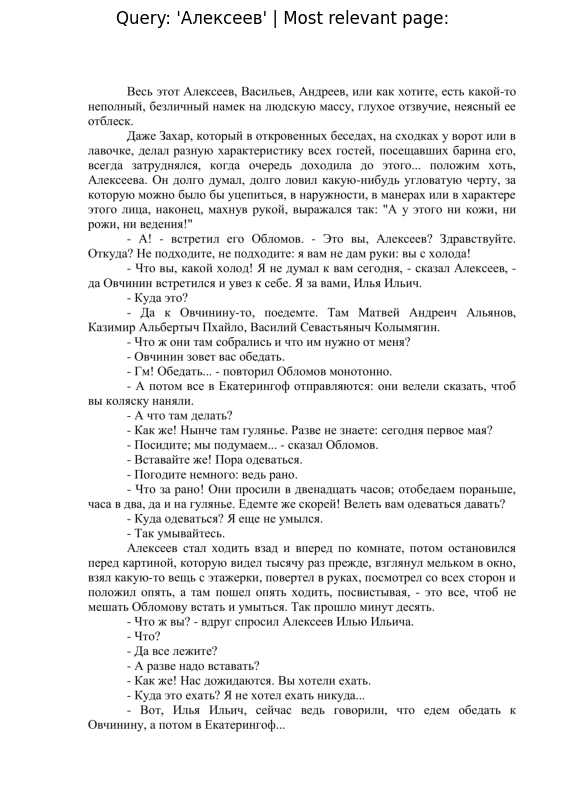

In [36]:
pdf_path = "Oblomov.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(20)

img = page.get_pixmap(dpi=300)


doc.close()


img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))


import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off')
plt.show()


In [37]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):



    query_embedding = model.encode(query,
                                   convert_to_tensor=True)


    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):


    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")

    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")

        print_wrapped(pages_and_chunks[index]["sentence_chunk"])

        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [38]:
query = "Штольц"


scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 1066 embeddings: 0.00034 seconds.


(tensor([0.2222, 0.1609, 0.1351, 0.1231, 0.1015]),
 tensor([ 738, 1061, 1041,  835,  206]))

In [39]:
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 1066 embeddings: 0.00033 seconds.
Query: Штольц

Results:
Score: 0.2222
пусть
Page number: 257


Score: 0.1609
В другой раз
Page number: 369


Score: 0.1351
Послушай, - сказал он, -
Page number: 362


Score: 0.1231
Не любовь ли?- спросил Штольц.
Page number: 292


Score: 0.1015
- Поди, чай, ночью
Page number: 68




## 3 RAG - пайплайн

In [40]:
!pip install mistralai -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.3/160.3 kB 9.7 MB/s eta 0:00:00


In [41]:
import pandas as pd
import numpy as np
import requests
import json
from sklearn.metrics.pairwise import cosine_similarity
import ast
from sentence_transformers import SentenceTransformer
from mistralai import Mistral
import getpass

Загрузка данных

In [42]:
df = pd.read_csv('text_chunks_and_embeddings_df.csv')

df.head(5)

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,1,Иван Александрович Гончаров Обломов ЧАСТЬ ПЕ...,2335,355,583.75,[-2.05821749e-02 1.08202565e-02 -4.40772064e-...
1,2,плечу все шире и шире.Хотя халат этот и утрати...,1871,287,467.75,[ 0.01025337 0.01901552 0.03540536 -0.042603...
2,2,"Задок у одного дивана оселся вниз, наклеенное ...",882,133,220.50,[-1.09641412e-02 1.38461636e-02 6.47770241e-...
3,3,тарелка с солонкой и с обглоданной косточкой д...,1707,257,426.75,[-7.80191086e-03 1.91717315e-02 2.62912177e-...
4,3,"Но план был еще далеко не весь обдуман, а непр...",988,158,247.00,[-0.01965263 0.02545456 0.01524404 -0.015158...


Подготовка эмбеддингов

In [43]:
embedding_model = SentenceTransformer(
    model_name_or_path="distiluse-base-multilingual-cased-v2",
    device="cpu"
)

Импорт Mistral API и преобразование эмбеддингов

In [47]:
mistral_api_key = getpass.getpass("Введите ваш Mistral API ключ: ")
client = Mistral(api_key=mistral_api_key)

# Преобразование эмбеддингов
def convert_embedding(embedding_str):
    if isinstance(embedding_str, np.ndarray):
        return embedding_str
    if isinstance(embedding_str, str):
        cleaned = embedding_str.strip('[]')
        numbers = [float(x.strip(',')) for x in cleaned.split() if x.strip(',')]
        return np.array(numbers, dtype=np.float32)
    return np.zeros(512, dtype=np.float32)

df['embedding'] = df['embedding'].apply(convert_embedding)
embeddings_matrix = np.vstack(df['embedding'].values)
print("Эмбеддинги готовы")

Введите ваш Mistral API ключ: ··········
Эмбеддинги готовы


Формирую пайплайн для обработки запросов и выдачи ответов.

In [48]:
def get_query_embedding(query):
    return embedding_model.encode([query])[0]

def find_relevant_chunks(query, top_k=3, similarity_threshold=0.3):
    query_embedding = get_query_embedding(query)
    similarities = cosine_similarity([query_embedding], embeddings_matrix)[0]
    top_indices = similarities.argsort()[-top_k:][::-1]

    relevant_chunks = []
    for idx in top_indices:
        if similarities[idx] >= similarity_threshold:
            relevant_chunks.append({
                'text': df.iloc[idx]['sentence_chunk'],
                'page_number': df.iloc[idx]['page_number'],
                'similarity': similarities[idx]
            })

    if not relevant_chunks and len(top_indices) > 0:
        idx = top_indices[0]
        relevant_chunks.append({
            'text': df.iloc[idx]['sentence_chunk'],
            'page_number': df.iloc[idx]['page_number'],
            'similarity': similarities[idx]
        })

    return relevant_chunks

def create_context(relevant_chunks, max_context_length=4000):
    context_parts = []
    current_length = 0

    for chunk in relevant_chunks:
        chunk_text = f"[Страница {chunk['page_number']}]: {chunk['text']}"
        if current_length + len(chunk_text) > max_context_length:
            break
        context_parts.append(chunk_text)
        current_length += len(chunk_text)

    return "\n\n".join(context_parts)

def generate_answer(query, context, model="mistral-large-latest"):
    system_prompt = """Ты - литературный эксперт по произведению "Обломов" И.А. Гончарова.
    Используй ТОЛЬКО предоставленный контекст. Отвечай на русском языке."""

    user_message = f"""КОНТЕКСТ:
{context}

ВОПРОС: {query}

ОТВЕТ:"""

    try:
        response = client.chat.complete(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_message}
            ],
            temperature=0.3,
            max_tokens=1000
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"Ошибка: {e}"

def ask_question(query, top_k=3, model="mistral-large-latest"):
    relevant_chunks = find_relevant_chunks(query, top_k=top_k)
    context = create_context(relevant_chunks)
    answer = generate_answer(query, context, model)

    return {
        "question": query,
        "answer": answer,
        "relevant_chunks": relevant_chunks,
        "chunks_used": len(relevant_chunks)
    }

Тестовый запрос


In [49]:
result = ask_question("Опишите характер Обломова")
print(f"Вопрос: {result['question']}")
print(f"Ответ: {result['answer']}")
print(f"Использовано отрывков: {result['chunks_used']}")

Вопрос: Опишите характер Обломова
Ответ: На основе предоставленного фрагмента романа "Обломов" И.А. Гончарова можно выделить следующие черты характера Ильи Ильича Обломова:

1. **Лень и апатия** – Обломов предпочитает лежать, дремать и избегать любой активности. Даже необходимые дела (например, покупки или хозяйственные заботы) он перекладывает на других, чтобы не нарушать своего покоя.

2. **Пассивность** – Он наблюдает за окружающими, но сам не проявляет инициативы. Ему удобно, когда кто-то (например, Тарантьев) "приносит жизнь и движение" в его комнату, не требуя от него участия.

3. **Потребность в комфорте и покое** – Обломов ценит тишину и отсутствие суеты. Даже присутствие Алексеева устраивает его, потому что тот не мешает его привычному образу жизни: молчит, дремлет или безучастно рассматривает вещи.

4. **Склонность к рефлексии и внутреннему монологу** – Он иногда испытывает потребность выразить свои мысли, но только при условии, что слушатель (как Алексеев) не будет спорить и

## 4 Интерфейс Gradio

На данном этапе создаётся интерактивный веб-интерфейс с использованием библиотеки **Gradio**, который позволяет протестировать работу RAG-пайплайна в режиме диалога.  


In [ ]:
!pip install gradio -q

In [ ]:
import gradio as gr

In [ ]:
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 📚 RAG Chatbot")
    gr.Markdown("Задай вопрос по книге — я отвечу, используя контент книги!")

    with gr.Row():
        with gr.Column(scale=5):
            question = gr.Textbox(label="Ваш вопрос", placeholder="Например: Что такое обломовщина?",  lines=10)
            send_btn = gr.Button("Отправить")
        with gr.Column(scale=10):
            answer = gr.Textbox(label="Ответ", interactive=False,  lines=10)

    send_btn.click(fn=ask_question, inputs=question, outputs=answer)

demo.launch(server_name="0.0.0.0", server_port=None)

## Вывод
В ходе работы был реализован RAG-пайплайн, объединяющий векторный поиск и генеративную языковую модель для анализа текста романа «Обломов» И.А. Гончарова.
Проект продемонстрировал, как методы Retrieval-Augmented Generation позволяют извлекать релевантную информацию из исходного текста и формировать осмысленные ответы на вопросы различной сложности.